In [1]:
import numpy as np
import os
from scipy.stats import norm
import math
import scipy.optimize as opt
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from pandas.tseries.offsets import DateOffset
from dateutil.relativedelta import relativedelta
from scipy.optimize import fsolve, root
import datetime
import copy
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm

## Fixed income functions

In [2]:
# curve data
os.chdir('C:/Users/Mikkel/OneDrive/CBS/CBS - FIN/THESIS/Main/data/')
EUSA = pd.read_excel('EUSA_data.xlsx')

# change dataframe layout
index = EUSA['Dates'].copy()
EUSA = pd.melt(EUSA.reset_index(),
               id_vars=['Dates'],
               value_vars=['6M', '1Y', '2Y', '3Y', '4Y', '5Y', '6Y', '7Y', '8Y', '9Y', '10Y', '12Y', '15Y', '20Y', '25Y', '30Y'],
               var_name='Maturity', value_name='Spot rate').set_index(['Dates'])
EUSA.name = 'EUSA'

# convert strings to float
def maturity_convert(Maturity):
    if Maturity[-1] == 'M':
        MaturityInYear = float(Maturity[:-1]) / 12  # if 6M -> 6/12
    else:
        MaturityInYear = float(Maturity[:-1])       # if xY -> float(x)
    return MaturityInYear

EUSA['Maturity (years)'] = EUSA['Maturity'].apply(lambda x: maturity_convert(x))

# change % to decimal
EUSA['Spot rate (decimal)'] = EUSA['Spot rate'].apply(lambda x: x / 100)

# cubic spline interpolation
def cubspline_curve(date, T, df_curve):
    S = interp1d(df_curve['Maturity (years)'][str(date)], 
                 df_curve['Spot rate (decimal)'][str(date)], 
                 kind='cubic', 
                 fill_value='extrapolate')
    return S(T)

def disc_factor(date, T, curve = EUSA):
    
    rate = np.log(1 + cubspline_curve(date, T, curve))

    return np.exp(-rate * T)    # curve is cont. comp.

def forw_rate(date, T, tau, curve = EUSA):

    P_0_T = disc_factor(date, T, curve)
    P_0_T_tau = disc_factor(date, T+tau, curve)

    return 1 / tau * (P_0_T / P_0_T_tau - 1)

def payment_schedule(date, expiry, tenor, tau):
    unadj_dates = []
    adj_dates = []

    t_0 = pd.Timestamp(date).date()
    t_m = (t_0 + DateOffset(months=(expiry * 12)) + pd.tseries.offsets.BusinessDay(0)).date()
    t_n = (t_m + DateOffset(months=(tenor * 12))).date()    #unadjusted for business days
    t_m_copy = t_m

    delta_months = relativedelta(months=+(tau * 12))

    while t_m_copy < t_n:
        unadj_dates.append(t_m_copy)
        t_m_copy = t_m_copy + delta_months

    unadj_dates.append(t_m_copy)

    for date in unadj_dates:
        adj_dates.append((date + pd.tseries.offsets.BusinessDay(0)).date())
    
    return adj_dates

def coverage(date, expiry, tenor, tau):
    coverage = []
    dates = []

    adj_dates = payment_schedule(date, expiry, tenor, tau)
    t_0 = pd.Timestamp(date).date()
    dates_roll = expiry + tau

    for i in range(1, len(adj_dates)):
        coverage.append(1 / 360 * (
            360 * (adj_dates[i].year - adj_dates[i - 1].year)
            + 30 * (adj_dates[i].month - adj_dates[i - 1].month)
            + min(30, adj_dates[i].day) 
            - min(30, adj_dates[i - 1].day)
            )
        )
        dates.append(dates_roll)
        dates_roll = dates_roll + coverage[i - 1]

    # coverage[0] = coverage
    # coverage[1] = tidspunkt for betaling
    return coverage, dates

def swap_rate(date, expiry, tenor, tau_floating, tau_fixed, curve = EUSA):
    floating_leg = 0
    fixed_leg = 0

    floating_coverage, floating_dates = coverage(date, expiry, tenor, tau_floating)
    fixed_coverage, fixed_dates = coverage(date, expiry, tenor, tau_fixed)

    for i in range(len(floating_dates)):
        floating_leg = floating_leg + disc_factor(date, floating_dates[i], curve) * floating_coverage[i] * forw_rate(date, floating_dates[i] - floating_coverage[i], floating_coverage[i],  curve)

    for i in range(len(fixed_dates)):
        fixed_leg = fixed_leg + disc_factor(date, fixed_dates[i]) * fixed_coverage[i]

    return floating_leg / fixed_leg

def annuity_func(date, expiry, tenor, tau, curve = EUSA):
    ann = 0
    cov, dates = coverage(date, expiry, tenor, tau)
    for i in range(len(dates)):
        ann = ann + disc_factor(date, dates[i], curve) * cov[i]
    return ann

def bachelier(F, K, sigma_normal, date, expiry, tenor, tau, t = 0):
    d = (F - K) / (sigma_normal * np.sqrt(expiry - t))
    return annuity_func(date, expiry, tenor, tau) * ((F - K) * norm.cdf(d) + sigma_normal * np.sqrt(expiry - t) * norm.pdf(d))

## Payer swaption functions

In [3]:
def trap_integration(xmin, xmax, N):
    # Computes integration points and weights for trapezoid scheme
    # integrates from xmin to xmax with N integration points
    uv = np.linspace(xmin, xmax, N)
    wgtv = np.ones(N)
    wgtv[[0, N - 1]] = 1 / 2
    wgtv = wgtv * (xmax - xmin) / (N - 1)
    return uv, wgtv

def char_func(u, T, theta, eta, z_0, lambd, b):
    v = 1/2 * (lambd * b)**2 * u * (u - 1)

    gamma = np.sqrt(theta**2 - 2 * eta**2 * v)
    A = 1 / eta**2 * theta * z_0 * (2 * np.log(2 * gamma / (theta + gamma - np.exp(-gamma * T)*(theta - gamma))) + (theta - gamma) * T)
    B = 2 * v * (1 - np.exp(-gamma * T)) / ((theta + gamma) * (1 - np.exp(-gamma * T)) + 2 * gamma * np.exp(-gamma * T))
    return np.exp(A + B * z_0)

def payer_price_SV(S, K, L, theta, eta, lambd, b, z_0, date, expiry, tenor):
    xmin = 0
    xmax = 2000
    int_points = 10000
    [u, wgt] = trap_integration(xmin, xmax, int_points)
    
    S_prime = b * S + (1 - b) * L + 0.025   # interim fix to the fact that ln(K_prime/S_prime) is undefined if either is negative
    K_prime = b * K + (1 - b) * L + 0.025

    integrand = np.real((np.exp(-(1/2 + 1j * u) * np.log(K_prime / S_prime)) * char_func(1/2 + 1j * u, expiry, theta, eta, z_0, lambd, b)) / (u**2 + 1/4))
    integral = sum(wgt * integrand)

    annuity = annuity_func(date, expiry, tenor, tau_floating_leg, EUSA)

    return annuity / b * (S_prime - K_prime / np.pi * integral)

## Misc inputs

In [4]:
###############################
date = datetime.date(2021,9,20)
###############################

tau_floating = 0.5      # EUSA swaps are semi-annual
tau_floating_leg = 0.5
tau_fixed = 1           # fixed rates paid annually

z_0 = 1

## Load data

In [5]:
swaption_data = pd.read_excel('swaption_cube_21.xlsx')
number_of_grids = len(pd.ExcelFile('swaption_cube_21.xlsx').sheet_names) / 2
xl_names = pd.ExcelFile('swaption_cube_21.xlsx').sheet_names[:int(number_of_grids)]

df_swaption_iv = []

for i in range(int(number_of_grids)):
    grid_i = pd.read_excel('swaption_cube_21.xlsx', sheet_name=(i), index_col = 0)
    grid_i.name = grid_i.index.name
    df_swaption_iv.append(grid_i)

# the swaption_iv holds the swaption grid for different strikes
# its dimensions are (m, n, #number of strikes)
# the calibration will be done for each (m, n)-pair with weights assigned for each strike
# access the grids by swaption_iv[i]
# access grid-points by swaption_iv[i].iloc[j,k]

In [6]:
swaption_data = pd.read_excel('swaption_cube_21.xlsx')
number_of_grids = len(pd.ExcelFile('swaption_cube_21.xlsx').sheet_names) / 2
xl_names = pd.ExcelFile('swaption_cube_21.xlsx').sheet_names[int(number_of_grids):]

df_swaption_strikes = []

for i in range(int(number_of_grids),2*int(number_of_grids)):
    grid_i = pd.read_excel('swaption_cube_21.xlsx', sheet_name=(i), index_col = 0)
    grid_i.name = grid_i.index.name
    df_swaption_strikes.append(grid_i)

# the swaption_iv holds the swaption grid for different strikes
# its dimensions are (m, n, #number of strikes)
# the calibration will be done for each (m, n)-pair with weights assigned for each strike
# access the grids by swaption_iv[i]
# access grid-points by swaption_iv[i].iloc[j,k]

## Set up lists with strikes, swap rates, and prices

In [7]:
swaption_expiry = np.array([1/12, 3/12, 6/12, 9/12, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 15, 20, 25, 30])
swaption_tenor = np.array([2, 5, 10])

df_strike = []
df_swap_rate = []
df_price = []

for i in range(len(df_swaption_iv)): # grid loop
    [M,N] = df_swaption_iv[i].shape

    df_strike_i = df_swaption_iv[i].copy()
    df_swap_rate_i = df_swaption_iv[i].copy()
    df_price_i = df_swaption_iv[i].copy()

    for m in range(M): # expiry loop
        T = swaption_expiry[m]      

        for n in range(N): # tenor loop
            tenor = swaption_tenor[n]
            moneyness = float(df_swaption_strikes[i].name) / 10000  # convert from bps. to decimal

            K = df_swaption_strikes[i].iloc[m,n] / 100
            S = K - moneyness

            normal_vol = df_swaption_iv[i].iloc[m,n] / 10000   # convert from bps. to decimal
            
            df_strike_i.iloc[m,n] = K
            df_swap_rate_i.iloc[m,n] = S
            df_price_i.iloc[m,n] = bachelier(S, K, normal_vol, date, T, tenor, tau_floating, t = 0)  # bachelier price (since data uses normal vols)
    
    df_strike.append(pd.DataFrame(df_strike_i))
    df_swap_rate.append(pd.DataFrame(df_swap_rate_i))
    df_price.append(pd.DataFrame(df_price_i))

df_strike, df_swap_rate, df_price

([         2Yr     5Yr    10Yr
  200                         
  1Mo   0.0156  0.0176  0.0208
  3Mo   0.0158  0.0177  0.0210
  6Mo   0.0162  0.0181  0.0213
  9Mo   0.0164  0.0184  0.0216
  1Yr   0.0167  0.0187  0.0219
  2Yr   0.0179  0.0199  0.0230
  3Yr   0.0194  0.0213  0.0241
  4Yr   0.0208  0.0226  0.0251
  5Yr   0.0218  0.0239  0.0259
  6Yr   0.0233  0.0250  0.0266
  7Yr   0.0246  0.0261  0.0271
  8Yr   0.0258  0.0269  0.0274
  9Yr   0.0270  0.0277  0.0277
  10Yr  0.0273  0.0280  0.0278
  12Yr  0.0286  0.0281  0.0273
  15Yr  0.0275  0.0275  0.0261
  20Yr  0.0248  0.0248  0.0238
  25Yr  0.0229  0.0229  0.0220
  30Yr  0.0212  0.0212  0.0212,
           2Yr     5Yr    10Yr
  100                         
  1Mo   0.0056  0.0075  0.0108
  3Mo   0.0058  0.0077  0.0110
  6Mo   0.0062  0.0081  0.0123
  9Mo   0.0064  0.0084  0.0116
  1Yr   0.0067  0.0087  0.0119
  2Yr   0.0079  0.0099  0.0130
  3Yr   0.0094  0.0113  0.0141
  4Yr   0.0108  0.0126  0.0151
  5Yr   0.0118  0.0139  0.0159
  6Yr  

## 10-year swap rate strips

In [8]:
strike_strips = []
swaprate_strips = []
price_strips = []

for i in range(len(df_strike)):
    strike_strips.append(df_strike[i].loc[:,"10Yr"])
    swaprate_strips.append(df_swap_rate[i].loc[:,"10Yr"])
    price_strips.append(df_price[i].loc[:,"10Yr"])

tenor = 10

### 10-year tenor swaptions, market implied volatility

In [8]:
expiries = ["2Yr", "5Yr", "8Yr", "10Yr", "15Yr","20Yr"]
strike_index = np.array([200, 100, 50, 25, 0, -25, -50, -100, -200])

iv_smiles = []

for i in range(len(expiries)):

    expiry = expiries[i]

    smile_i = pd.Series([df_swaption_iv[0].loc[expiry, "10Yr"], df_swaption_iv[1].loc[expiry,"10Yr"], df_swaption_iv[2].loc[expiry,"10Yr"], df_swaption_iv[3].loc[expiry,"10Yr"], 
                         df_swaption_iv[4].loc[expiry,"10Yr"], # ATM
                         df_swaption_iv[5].loc[expiry,"10Yr"], df_swaption_iv[6].loc[expiry,"10Yr"], df_swaption_iv[7].loc[expiry,"10Yr"], df_swaption_iv[8].loc[expiry,"10Yr"]],
                         index = strike_index)
    iv_smiles.append(smile_i)

## Calibration 1: fixed parameters

In [ ]:
expiry = np.array([1/12, 3/12, 6/12, 9/12, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 15, 20, 25, 30])

def pricing_fixed(lambd, b, eta, theta):

    M = len(expiry)
    prices = copy.deepcopy(price_strips)
    
    print("lambda =", lambd, "b =", b, "eta =", eta, "theta =", theta)
    for m in range(M):  # option expiry
        T = expiry[m]

        for i in range(len(strike_strips)): # strike level
            
            K = strike_strips[i][m]
            S = swaprate_strips[i][m]

            model_price = payer_price_SV(S, K, S, theta, eta, lambd, b, z_0, date, T, tenor)
            prices[i][m] = model_price

    return prices

# moneyness            +200  +100  +50  +25   ATM  -25   -50  -100  -200
weightings = np.array([0.05, 0.05, 0.1, 0.15, 0.3, 0.15, 0.1, 0.05, 0.05])

weights = copy.deepcopy(price_strips)
for n in range(len(weightings)):
    weights[n].iloc[:] = weightings[n]

bounds = ((1e-8, np.inf),(1e-8, np.inf),(1e-8, np.inf),(1e-8, np.inf))

init_lambd = 0.2
init_b = 0.25
init_eta = 1.2
init_theta = 0.3
initguess = [init_lambd, init_b, init_eta, init_theta]

def Err(x):
    lambd, b, eta, theta = x
    err = np.sum(weights * (np.array(pricing_fixed(lambd, b, eta, theta)) - np.array(price_strips))**2)
    print("objective function =", err)
    return err

res = opt.minimize(Err, initguess, bounds = bounds, tol = 1e-12)
lambd, b, eta, theta = res.x

In [9]:
b =	0.24596347052385759
eta = 1.273878828280068
theta = 0.27310990019856796
lambd =	0.19384237338314136 

### Model implied volatilities

In [ ]:
expiries = pd.Series(data = np.array([1/12, 3/12, 6/12, 9/12, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 15, 20, 25, 30]), 
                     index = ["1Mo","3Mo","6Mo","9Mo","1Yr","2Yr","3Yr","4Yr", "5Yr", "6Yr","7Yr", "8Yr", "9Yr", "10Yr", "12Yr","15Yr","20Yr", "25Yr", "30Yr"])

points = ["2Yr", "5Yr", "8Yr", "10Yr", "15Yr","20Yr"]

IV_1 = []

for i in range(len(points)):

    S = swaprate_strips[4][points[i]]

    strikes = np.linspace(S -200/10000, S + 200/10000, 49)
    IV_index = np.round(np.linspace(-200, 200, len(strikes)),2)

    IV_i = pd.Series(np.zeros(len(strikes)),
                     index = IV_index)

    T = expiries[points[i]]
    print("T = ", T)

    for n in range(len(strikes)):

        K = strikes[n]
    
        def Root_Solving(x):
            return bachelier(S, K, x, date, T, tenor, tau_floating, t = 0) - payer_price_SV(S, K, S, theta, eta, lambd, b, z_0, date, T, tenor)

        res = fsolve(Root_Solving, 0.01)

        IV_i.iloc[n] = res * 10000   # convert to bp
        print(IV_i.iloc[n])

    IV_1.append(IV_i)

### Implied volatility plots: model vs. market

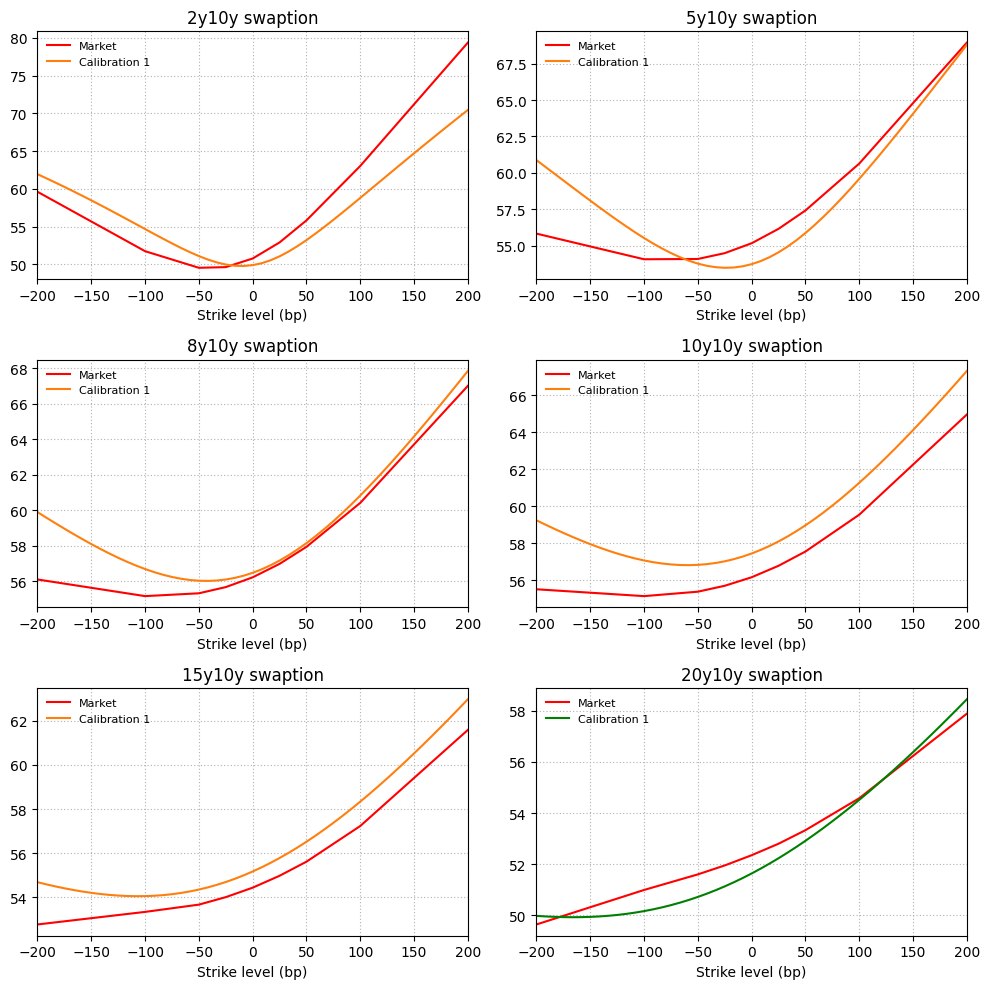

In [17]:
fig, ax = plt.subplots(3, 2, figsize=(10,10))

ax[0, 0].plot(iv_smiles[0].index, iv_smiles[0], label = 'Market', color = 'r')
ax[0, 0].plot(IV_1[0].index, IV_1[0], label = 'Calibration 1', color = '#ff7f0e')
ax[0, 0].set_title('2y10y swaption')
ax[0, 0].set_xlim(min(IV_index), max(IV_index))
ax[0, 0].set_xlabel('Moneyness (bp)')
ax[0, 0].grid(ls = (0,(1,2)))
ax[0, 0].legend(frameon=False, fontsize=8)

ax[0, 1].plot(iv_smiles[1].index, iv_smiles[1], label = 'Market', color = 'r')
ax[0, 1].plot(IV_1[1].index, IV_1[1], label = 'Calibration 1', color = '#ff7f0e')
ax[0, 1].set_title('5y10y swaption')
ax[0, 1].set_xlim(min(IV_index), max(IV_index))
ax[0, 1].set_xlabel('Moneyness (bp)')
ax[0, 1].grid(ls = (0,(1,2)))
ax[0, 1].legend(frameon=False, fontsize=8)

ax[1, 0].plot(iv_smiles[2].index, iv_smiles[2], label = 'Market', color = 'r')
ax[1, 0].plot(IV_1[2].index, IV_1[2], label = 'Calibration 1', color = '#ff7f0e')
ax[1, 0].set_title('8y10y swaption')
ax[1, 0].set_xlim(min(IV_index), max(IV_index))
ax[1, 0].set_xlabel('Moneyness (bp)')
ax[1, 0].grid(ls = (0,(1,2)))
ax[1, 0].legend(frameon=False, fontsize=8)

ax[1, 1].plot(iv_smiles[3].index, iv_smiles[3], label = 'Market', color = 'r')
ax[1, 1].plot(IV_1[3].index, IV_1[3], label = 'Calibration 1', color = '#ff7f0e')
ax[1, 1].set_title('10y10y swaption')
ax[1, 1].set_xlim(min(IV_index), max(IV_index))
ax[1, 1].set_xlabel('Moneyness (bp)')
ax[1, 1].grid(ls = (0,(1,2)))
ax[1, 1].legend(frameon=False, fontsize=8)

ax[2, 0].plot(iv_smiles[4].index, iv_smiles[4], label = 'Market', color = 'r')
ax[2, 0].plot(IV_1[4].index, IV_1[4], label = 'Calibration 1', color = '#ff7f0e')
ax[2, 0].set_title('15y10y swaption')
ax[2, 0].set_xlim(min(IV_index), max(IV_index))
ax[2, 0].set_xlabel('Moneyness (bp)')
ax[2, 0].grid(ls = (0,(1,2)))
ax[2, 0].legend(frameon=False, fontsize=8)

ax[2, 1].plot(iv_smiles[5].index, iv_smiles[5], label = 'Market', color = 'r')
ax[2, 1].plot(IV_1[5].index, IV_1[5], label = 'Calibration 1', color = 'g')
ax[2, 1].set_title('20y10y swaption')
ax[2, 1].set_xlim(min(IV_index), max(IV_index))
ax[2, 1].set_xlabel('Moneyness (bp)')
ax[2, 1].grid(ls = (0,(1,2)))
ax[2, 1].legend(frameon=False, fontsize=8)

fig.tight_layout()
plt.show()

## Errors across all option expiries
##### Model

In [ ]:
expiries = pd.Series(data = np.array([1/12, 3/12, 6/12, 9/12, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 15, 20, 25, 30]), 
                     index = ["1Mo","3Mo","6Mo","9Mo","1Yr","2Yr","3Yr","4Yr", "5Yr", "6Yr","7Yr", "8Yr", "9Yr", "10Yr", "12Yr","15Yr","20Yr", "25Yr", "30Yr"])

points = ["2Yr","3Yr","4Yr", "5Yr", "6Yr","7Yr", "8Yr", "9Yr", "10Yr", "12Yr","15Yr","20Yr", "25Yr", "30Yr"]  # errors for very short option expiries

IV_1_errors = []

for i in range(len(points)):

    S = swaprate_strips[4][points[i]]

    strikes = np.array([S-200/10000, S-100/10000, S-50/10000, S-25/10000,
                    S-0/10000,
                    S+25/10000, S+50/10000, S+100/10000, S+200/10000])

    IV_index = np.round(np.linspace(-200, 200, len(strikes)),2)

    IV_i = pd.Series(np.zeros(len(strikes)),
                     index = IV_index)
  
    T = expiries[points[i]]
    print("T = ", T)

    for n in range(len(strikes)):

        K = strikes[n]
            
        def Root_Solving(x):
            return bachelier(S, K, x, date, T, tenor, tau_floating, t = 0) - payer_price_SV(S, K, S, theta, eta, lambd, b, z_0, date, T, tenor)

        res = fsolve(Root_Solving, 0.01)

        IV_i.iloc[n] = res * 10000   # convert to bp
        print(IV_i.iloc[n])

    IV_1_errors.append(IV_i)

##### Market

In [15]:
expiries = ["2Yr","3Yr","4Yr", "5Yr", "6Yr","7Yr", "8Yr", "9Yr", "10Yr", "12Yr","15Yr","20Yr", "25Yr", "30Yr"]
strike_index = np.array([-200, -100, -50, -25, 0, 25, 50, 100, 200])

iv_smiles = []

for i in range(len(expiries)):
    expiry = expiries[i]
    smile_i = pd.Series([df_swaption_iv[8].loc[expiry,"10Yr"], df_swaption_iv[7].loc[expiry,"10Yr"], df_swaption_iv[6].loc[expiry,"10Yr"], df_swaption_iv[5].loc[expiry,"10Yr"],                   
                         df_swaption_iv[4].loc[expiry,"10Yr"], # ATM
                         df_swaption_iv[3].loc[expiry,"10Yr"], df_swaption_iv[2].loc[expiry,"10Yr"], df_swaption_iv[1].loc[expiry,"10Yr"], df_swaption_iv[0].loc[expiry, "10Yr"]],
                         index = strike_index)
    iv_smiles.append(smile_i)

In [16]:
rmse = []

for i in range(len(points)):

    rmse_i = np.sqrt(mean_squared_error(iv_smiles[i], IV_1_errors[i]))
    rmse.append(rmse_i)

avg_rmse = np.average(rmse)
display(pd.DataFrame(data= rmse, index = expiries, columns = ['RMSE, Calibration 1']))
print("Average root mean squared error =", avg_rmse)

,"RMSE, Calibration 1"
2Yr,3.727709
3Yr,3.216941
4Yr,2.413578
5Yr,2.023478
6Yr,1.684332
7Yr,1.479747
8Yr,1.432768
9Yr,1.794682
10Yr,1.980803
12Yr,1.786037


Average root mean squared error = 1.782852572243122


## Calibration with constant parameters and $\lambda(t)$

In [ ]:
expiry = np.array([1/12, 3/12, 6/12, 9/12, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 15, 20, 25, 30])

def pricing_lambd(b, eta, theta, lambda_1, lambda_2, lambda_3, lambda_4, lambda_5, lambda_6, lambda_7, lambda_8, lambda_9, lambda_10, lambda_11, lambda_12, lambda_13, lambda_14, lambda_15, lambda_16, lambda_17, lambda_18, lambda_19):

    lambdas = np.array([lambda_1, lambda_2, lambda_3, lambda_4, lambda_5, lambda_6, lambda_7, lambda_8, lambda_9, lambda_10, lambda_11, lambda_12, lambda_13, lambda_14, lambda_15, lambda_16, lambda_17, lambda_18, lambda_19])

    M = len(expiry)
    prices = copy.deepcopy(price_strips)
    
    for m in range(M):  # option expiry
        T = expiry[m]
        lambd = lambdas[m]
        print("b =", b, "eta = ", eta, "theta =", theta, "lambda =", lambd)
        for i in range(len(strike_strips)): # strike level
            
            K = strike_strips[i][m]
            S = swaprate_strips[i][m]

            model_price = payer_price_SV(S, K, S, theta, eta, lambd, b, z_0, date, T, tenor)
            prices[i][m] = model_price

    return prices

# moneyness            +200  +100  +50  +25   ATM  -25   -50  -100  -200
weightings = np.array([0.05, 0.05, 0.1, 0.15, 0.3, 0.15, 0.1, 0.05, 0.05])

weights = copy.deepcopy(price_strips)
for n in range(len(weightings)):
    weights[n].iloc[:] = weightings[n]

bounds = ((1e-8, np.inf),(1e-8, np.inf),(1e-8, np.inf),
          (1e-8, np.inf), (1e-8, np.inf), (1e-8, np.inf), (1e-8, np.inf), (1e-8, np.inf), (1e-8, np.inf), (1e-8, np.inf), (1e-8, np.inf), (1e-8, np.inf), (1e-8, np.inf), 
          (1e-8, np.inf), (1e-8, np.inf), (1e-8, np.inf), (1e-8, np.inf), (1e-8, np.inf), (1e-8, np.inf), (1e-8, np.inf), (1e-8, np.inf), (1e-8, np.inf))

init_b = 0.15
init_eta = 1.5
init_theta = 0.40
init_lambda_1 = 0.3
init_lambda_2 = 0.3
init_lambda_3 = 0.3
init_lambda_4 = 0.3
init_lambda_5 = 0.3
init_lambda_6 = 0.3
init_lambda_7 = 0.3
init_lambda_8 = 0.3
init_lambda_9 = 0.3
init_lambda_10 = 0.3
init_lambda_11 = 0.3
init_lambda_12 = 0.3
init_lambda_13 = 0.3
init_lambda_14 = 0.3
init_lambda_15 = 0.3
init_lambda_16 = 0.3
init_lambda_17 = 0.3
init_lambda_18 = 0.3
init_lambda_19 = 0.3
initguess = [init_b, init_eta, init_theta,
             init_lambda_1, init_lambda_2, init_lambda_3, init_lambda_4, init_lambda_5, init_lambda_6, init_lambda_7, init_lambda_8, init_lambda_9, init_lambda_10, init_lambda_11, init_lambda_12, init_lambda_13, init_lambda_14, init_lambda_15, init_lambda_16, init_lambda_17, init_lambda_18, init_lambda_19]

def Err(x):
    b, eta, theta, lambda_1, lambda_2, lambda_3, lambda_4, lambda_5, lambda_6, lambda_7, lambda_8, lambda_9, lambda_10, lambda_11, lambda_12, lambda_13, lambda_14, lambda_15, lambda_16, lambda_17, lambda_18, lambda_19 = x
    err = np.sum(weights * (np.array(pricing_lambd(b, eta, theta, lambda_1, lambda_2, lambda_3, lambda_4, lambda_5, lambda_6, lambda_7, lambda_8, lambda_9, lambda_10, lambda_11, lambda_12, lambda_13, lambda_14, lambda_15, lambda_16, lambda_17, lambda_18, lambda_19))
                            -np.array(price_strips))**2)
    print("Objective function =", err)
    return err

res = opt.minimize(Err, initguess, bounds = bounds, tol = 1e-12)
b, eta, theta, lambda_1, lambda_2, lambda_3, lambda_4, lambda_5, lambda_6, lambda_7, lambda_8, lambda_9, lambda_10, lambda_11, lambda_12, lambda_13, lambda_14, lambda_15, lambda_16, lambda_17, lambda_18, lambda_19 = res.x
lambdas = pd.Series(data = np.array([lambda_1, lambda_2, lambda_3, lambda_4, lambda_5, lambda_6, lambda_7, lambda_8, lambda_9, lambda_10, lambda_11, lambda_12, lambda_13, lambda_14, lambda_15, lambda_16, lambda_17, lambda_18, lambda_19]), 
                    index = ["1Mo","3Mo","6Mo","9Mo","1Yr","2Yr","3Yr","4Yr", "5Yr", "6Yr","7Yr", "8Yr", "9Yr", "10Yr", "12Yr","15Yr","20Yr", "25Yr", "30Yr"])

In [17]:
b =	0.250571973748702
eta = 1.49189308211944
theta = 0.455040399026276
lambdas = pd.Series(data = np.array([0.16328444,0.17134324,0.17588378,0.18259829,0.18762413,0.19757024,0.19972312,0.19790383,0.19491882,0.19187272,0.18962228,0.18776167,0.18514741,0.18400098,0.1836981,0.18566882,0.19089332,0.19410368,0.19036148]), 
                    index = ["1Mo","3Mo","6Mo","9Mo","1Yr","2Yr","3Yr","4Yr", "5Yr", "6Yr","7Yr", "8Yr", "9Yr", "10Yr", "12Yr","15Yr","20Yr", "25Yr", "30Yr"])

### Model implied volatilities

In [ ]:
expiries = pd.Series(data = np.array([1/12, 3/12, 6/12, 9/12, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 15, 20, 25, 30]), 
                     index = ["1Mo","3Mo","6Mo","9Mo","1Yr","2Yr","3Yr","4Yr", "5Yr", "6Yr","7Yr", "8Yr", "9Yr", "10Yr", "12Yr","15Yr","20Yr", "25Yr", "30Yr"])

points = ["2Yr", "5Yr", "8Yr", "10Yr", "15Yr","20Yr"]

IV_2 = []

for i in range(len(points)):
    lambd = lambdas[points[i]]

    S = swaprate_strips[4][points[i]]

    strikes = np.linspace(S -200/10000, S + 200/10000, 49)
    IV_index = np.round(np.linspace(-200, 200, len(strikes)),2)

    IV_i = pd.Series(np.zeros(len(strikes)),
                     index = IV_index)
  
    T = expiries[points[i]]
    print("T = ", T)

    for n in range(len(strikes)):

        K = strikes[n]    
        def Root_Solving(x):
            return bachelier(S, K, x, date, T, tenor, tau_floating, t = 0) - payer_price_SV(S, K, S, theta, eta, lambd, b, z_0, date, T, tenor)
        res = fsolve(Root_Solving, 0.01)

        IV_i.iloc[n] = res * 10000   # convert to bp
        print(IV_i.iloc[n])
    IV_2.append(IV_i)

In [24]:
expiries = ["2Yr", "5Yr", "8Yr", "10Yr", "15Yr","20Yr"]
strike_index = np.array([200, 100, 50, 25, 0, -25, -50, -100, -200])

iv_smiles = []

for i in range(len(expiries)):

    expiry = expiries[i]

    smile_i = pd.Series([df_swaption_iv[0].loc[expiry, "10Yr"], df_swaption_iv[1].loc[expiry,"10Yr"], df_swaption_iv[2].loc[expiry,"10Yr"], df_swaption_iv[3].loc[expiry,"10Yr"], 
                         df_swaption_iv[4].loc[expiry,"10Yr"], # ATM
                         df_swaption_iv[5].loc[expiry,"10Yr"], df_swaption_iv[6].loc[expiry,"10Yr"], df_swaption_iv[7].loc[expiry,"10Yr"], df_swaption_iv[8].loc[expiry,"10Yr"]],
                         index = strike_index)
    iv_smiles.append(smile_i)

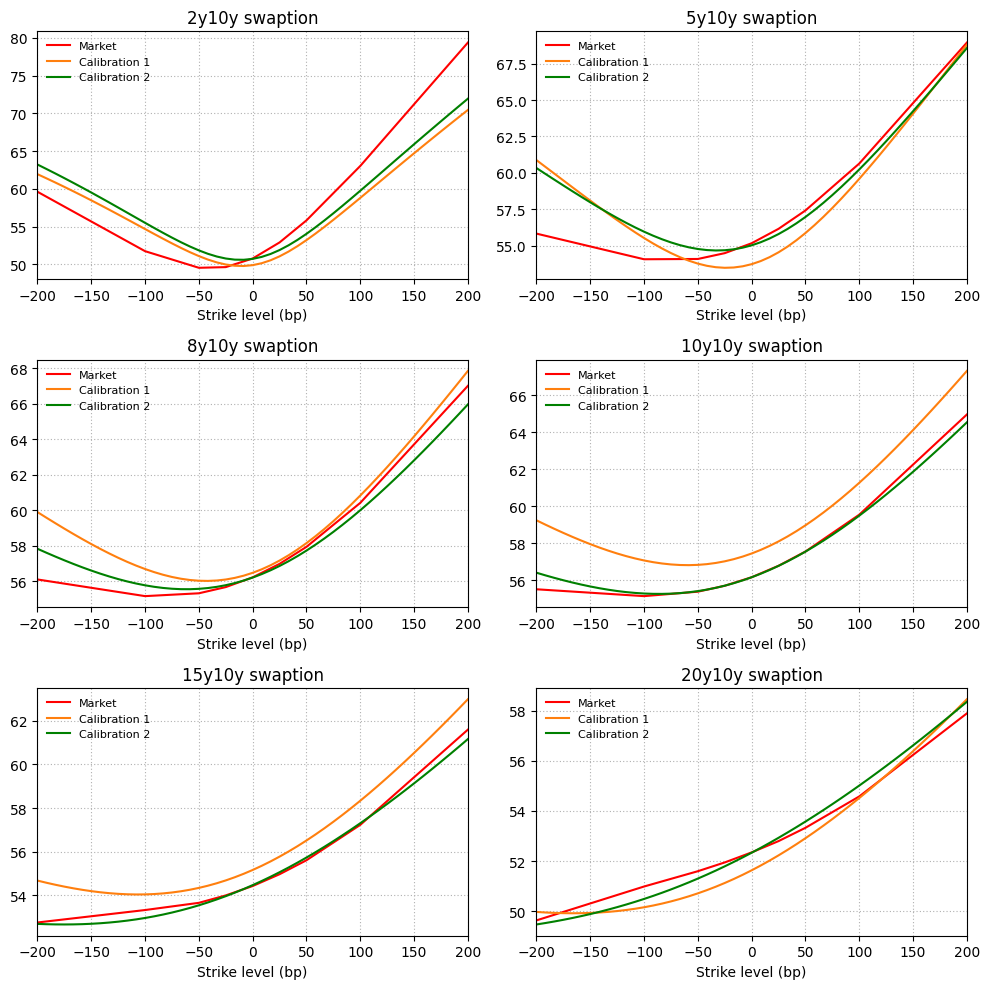

In [25]:
fig, ax = plt.subplots(3, 2, figsize=(10,10))

ax[0, 0].plot(iv_smiles[0].index, iv_smiles[0], label = 'Market', color = 'r')
ax[0, 0].plot(IV_1[0].index, IV_1[0], label = 'Calibration 1', color = '#ff7f0e')
ax[0, 0].plot(IV_2[0].index, IV_2[0], label = 'Calibration 2', color = 'g')
ax[0, 0].set_title('2y10y swaption')
ax[0, 0].set_xlim(min(IV_index), max(IV_index))
ax[0, 0].set_xlabel('Moneyness (bp)')
ax[0, 0].grid(ls = (0,(1,2)))
ax[0, 0].legend(frameon=False, fontsize=8)

ax[0, 1].plot(iv_smiles[1].index, iv_smiles[1], label = 'Market', color = 'r')
ax[0, 1].plot(IV_1[1].index, IV_1[1], label = 'Calibration 1', color = '#ff7f0e')
ax[0, 1].plot(IV_2[1].index, IV_2[1], label = 'Calibration 2', color = 'g')
ax[0, 1].set_title('5y10y swaption')
ax[0, 1].set_xlim(min(IV_index), max(IV_index))
ax[0, 1].set_xlabel('Moneyness (bp)')
ax[0, 1].grid(ls = (0,(1,2)))
ax[0, 1].legend(frameon=False, fontsize=8)

ax[1, 0].plot(iv_smiles[2].index, iv_smiles[2], label = 'Market', color = 'r')
ax[1, 0].plot(IV_1[2].index, IV_1[2], label = 'Calibration 1', color = '#ff7f0e')
ax[1, 0].plot(IV_2[2].index, IV_2[2], label = 'Calibration 2', color = 'g')
ax[1, 0].set_title('8y10y swaption')
ax[1, 0].set_xlim(min(IV_index), max(IV_index))
ax[1, 0].set_xlabel('Moneyness (bp)')
ax[1, 0].grid(ls = (0,(1,2)))
ax[1, 0].legend(frameon=False, fontsize=8)

ax[1, 1].plot(iv_smiles[3].index, iv_smiles[3], label = 'Market', color = 'r')
ax[1, 1].plot(IV_1[3].index, IV_1[3], label = 'Calibration 1', color = '#ff7f0e')
ax[1, 1].plot(IV_2[3].index, IV_2[3], label = 'Calibration 2', color = 'g')
ax[1, 1].set_title('10y10y swaption')
ax[1, 1].set_xlim(min(IV_index), max(IV_index))
ax[1, 1].set_xlabel('Moneyness (bp)')
ax[1, 1].grid(ls = (0,(1,2)))
ax[1, 1].legend(frameon=False, fontsize=8)

ax[2, 0].plot(iv_smiles[4].index, iv_smiles[4], label = 'Market', color = 'r')
ax[2, 0].plot(IV_1[4].index, IV_1[4], label = 'Calibration 1', color = '#ff7f0e')
ax[2, 0].plot(IV_2[4].index, IV_2[4], label = 'Calibration 2', color = 'g')
ax[2, 0].set_title('15y10y swaption')
ax[2, 0].set_xlim(min(IV_index), max(IV_index))
ax[2, 0].set_xlabel('Moneyness (bp)')
ax[2, 0].grid(ls = (0,(1,2)))
ax[2, 0].legend(frameon=False, fontsize=8)

ax[2, 1].plot(iv_smiles[5].index, iv_smiles[5], label = 'Market', color = 'r')
ax[2, 1].plot(IV_1[5].index, IV_1[5], label = 'Calibration 1', color = '#ff7f0e')
ax[2, 1].plot(IV_2[5].index, IV_2[5], label = 'Calibration 2', color = 'g')
ax[2, 1].set_title('20y10y swaption')
ax[2, 1].set_xlim(min(IV_index), max(IV_index))
ax[2, 1].set_xlabel('Moneyness (bp)')
ax[2, 1].grid(ls = (0,(1,2)))
ax[2, 1].legend(frameon=False, fontsize=8)

fig.tight_layout()
plt.show()

## Errors across all option expiries
##### Model

In [18]:
expiries = pd.Series(data = np.array([1/12, 3/12, 6/12, 9/12, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 15, 20, 25, 30]), 
                     index = ["1Mo","3Mo","6Mo","9Mo","1Yr","2Yr","3Yr","4Yr", "5Yr", "6Yr","7Yr", "8Yr", "9Yr", "10Yr", "12Yr","15Yr","20Yr", "25Yr", "30Yr"])

points = ["2Yr","3Yr","4Yr", "5Yr", "6Yr","7Yr", "8Yr", "9Yr", "10Yr", "12Yr","15Yr","20Yr", "25Yr", "30Yr"]

IV_2_errors = []

for i in range(len(points)):

    lambd = lambdas[points[i]]
    S = swaprate_strips[4][points[i]]

    strikes = np.array([S-200/10000, S-100/10000, S-50/10000, S-25/10000,
                        S-0/10000,
                        S+25/10000, S+50/10000, S+100/10000, S+200/10000])

    IV_index = np.round(np.linspace(-200, 200, len(strikes)),2)

    IV_i = pd.Series(np.zeros(len(strikes)),
                     index = IV_index)
  
    T = expiries[points[i]]
    print("T = ", T)

    for n in range(len(strikes)):

        K = strikes[n]
        def Root_Solving(x):
            return bachelier(S, K, x, date, T, tenor, tau_floating, t = 0) - payer_price_SV(S, K, S, theta, eta, lambd, b, z_0, date, T, tenor)
        res = fsolve(Root_Solving, 0.01)

        IV_i.iloc[n] = res * 10000   # convert to bp
        print(IV_i.iloc[n])

    IV_2_errors.append(IV_i)

T =  2.0
63.23807171792836
55.515546445249136
51.86573010290926
50.78846517381344
50.74181432295007
51.91100000792245
54.058717375505914
59.76658334578072
71.95781666347538
T =  3.0
62.6144309142099
55.97160709171984
53.389112662314
52.80817416525451
52.96894427300248
53.94005431861855
55.61297438370019
60.26226707539769
71.12725148717944
T =  4.0
61.507029612894584
56.06119638617107
54.290906571006
54.013618926807275
54.2862546969287
55.137545697929106
56.508712178463995
60.35135384843444
69.85371596957194
T =  5.0
60.3290228214536
55.96178582747104
54.77443253119615
54.68940284672653
55.027200098166944
55.80063043329783
56.97374267517122
60.233868590927024
68.56455890111218
T =  6.0
59.38070387762958
55.92759764132069
55.16658765534843
55.21150141031778
55.5908489367842
56.31020035789662
57.34575880692872
60.17789321622154
67.54614796336665
T =  7.0
58.60528729578562
55.91689254748141
55.476356168620114
55.6143586642949
56.02323480898484
56.70501838219973
57.64296358634579
60.1577876

##### Market

In [19]:
expiries = ["2Yr","3Yr","4Yr", "5Yr", "6Yr","7Yr", "8Yr", "9Yr", "10Yr", "12Yr","15Yr","20Yr", "25Yr", "30Yr"]
strike_index = np.array([-200, -100, -50, -25, 0, 25, 50, 100, 200])

iv_smiles = []

for i in range(len(expiries)):
    expiry = expiries[i]
    smile_i = pd.Series([df_swaption_iv[8].loc[expiry,"10Yr"], df_swaption_iv[7].loc[expiry,"10Yr"], df_swaption_iv[6].loc[expiry,"10Yr"], df_swaption_iv[5].loc[expiry,"10Yr"],                   
                         df_swaption_iv[4].loc[expiry,"10Yr"], # ATM
                         df_swaption_iv[3].loc[expiry,"10Yr"], df_swaption_iv[2].loc[expiry,"10Yr"], df_swaption_iv[1].loc[expiry,"10Yr"], df_swaption_iv[0].loc[expiry, "10Yr"]],
                         index = strike_index)
    iv_smiles.append(smile_i)

In [20]:
rmse = []

for i in range(len(points)):

    rmse_i = np.sqrt(mean_squared_error(iv_smiles[i], IV_2_errors[i]))
    rmse.append(rmse_i)

avg_rmse = np.average(rmse)
display(pd.DataFrame(data= rmse, index = expiries, columns = ['RMSE, Calibration 2']))
print("Average root mean squared error =", avg_rmse)

,"RMSE, Calibration 2"
2Yr,3.398469
3Yr,2.661789
4Yr,1.964006
5Yr,1.666095
6Yr,1.266199
7Yr,0.969543
8Yr,0.728015
9Yr,0.527110
10Yr,0.333929
12Yr,0.241250


Average root mean squared error = 1.0862337673294051


## Calibration with $\lambda(t), b(t), \eta(t)$

In [29]:
strike_strips = []
swaprate_strips = []
price_strips = []

for i in range(len(df_strike)):
    strike_strips.append(df_strike[i].loc[:,"10Yr"])
    swaprate_strips.append(df_swap_rate[i].loc[:,"10Yr"])
    price_strips.append(df_price[i].loc[:,"10Yr"])

In [ ]:
expiry = np.array([1/12, 3/12, 6/12, 9/12, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 15, 20, 25, 30])

# moneyness         +200  +100  +50  +25   ATM  -25   -50  -100  -200
weights = np.array([0.05, 0.05, 0.1, 0.15, 0.3, 0.15, 0.1, 0.05, 0.05])

lambd_calibrated = price_strips[0].copy()
b_calibrated = price_strips[0].copy()
eta_calibrated = price_strips[0].copy()
model_prices = price_strips[0].copy()

theta = 0.455040399026276

M = len(expiry)

for m in range(M):  # calibrate swaption m
    T = expiry[m]
    print("Expiry = ", T)

    strikes_i = []
    swap_rate_i = []
    market_price_i = []

    for i in range(len(strike_strips)): # strikes loop

        strikes_i.append(strike_strips[i].iloc[m])
        swap_rate_i.append(swaprate_strips[i].iloc[m])
        market_price_i.append(price_strips[i].iloc[m])

    for p in range(1):  # calibrate (m,n)-swaption
        strikes = np.array(strikes_i)
        obs_prices = np.array(market_price_i)
        obs_swap_rates = np.array(swap_rate_i)

        bounds = ((1e-8, np.inf),(1e-8, np.inf),(1e-8, np.inf))

        init_lambd = 0.5
        init_b = 0.50
        init_eta = 0.50
        initguess = [init_lambd, init_b, init_eta]

        def Err(x):
            lambd, b, eta = x

            price_hat = []

            for i in range(len(strike_strips)):
                
                price_hat.append(payer_price_SV(obs_swap_rates[i], strikes[i], obs_swap_rates[i], theta, eta, lambd, b, z_0, date, T, tenor))

            price_hat = np.array(price_hat)
            err = np.sum(weights * (price_hat - obs_prices)**2)

            return err

    res = opt.minimize(Err, initguess, bounds = bounds, tol = 1e-14)
    lambd, b, eta = res.x

    lambd_calibrated[m] = lambd
    b_calibrated[m] = b
    eta_calibrated[m] = eta

    print('\n', "observed ATM price = ", market_price_i[4]) # market price
    print('\n', "calibrated ATM price = ", payer_price_SV(obs_swap_rates[4], strikes[4], obs_swap_rates[4], theta, eta, lambd, b, z_0, date, T, tenor))
    print('\n', 'calibrated lambda', lambd)
    print('\n', 'calibrated b', b)
    print('\n', 'calibrated eta', eta)

In [47]:
lambd_calibrated = pd.Series(data = np.array([0.16246652, 0.16951984, 0.1725005 , 0.17812848, 0.18949832, 0.19736336, 0.20056205, 0.1974455 , 0.1909636, 0.18947078, 0.18836681, 0.18719459, 0.18481664, 0.18382116, 0.18447391, 0.187066, 0.18993899, 0.19612096, 0.19484798]), 
                             index = ["1Mo","3Mo","6Mo","9Mo","1Yr","2Yr","3Yr","4Yr", "5Yr", "6Yr","7Yr", "8Yr", "9Yr", "10Yr", "12Yr","15Yr","20Yr", "25Yr", "30Yr"])

b_calibrated = pd.Series(data = np.array([1.28999918, 1.2998979 , 1.31486662, 1.32999832, 1.13315251, 0.70772095, 0.57534925, 0.47167497, 0.38281141, 0.36311661, 0.34131284, 0.31877607, 0.29744674, 0.26819894, 0.26364688, 0.2446193 , 0.21581184, 0.20789896, 0.20751869]), 
                         index = ["1Mo","3Mo","6Mo","9Mo","1Yr","2Yr","3Yr","4Yr", "5Yr", "6Yr","7Yr", "8Yr", "9Yr", "10Yr", "12Yr","15Yr","20Yr", "25Yr", "30Yr"])

eta_calibrated = pd.Series(data = np.array([0.81810631, 0.72850604, 0.74740941, 0.83704278, 1.63601765, 1.46253091, 1.52486403, 1.45325872, 1.23647065, 1.32896457, 1.40056102, 1.44624521, 1.46307495, 1.47631064, 1.55352, 1.61681504, 1.40152722, 1.73070909, 2.04864653]), 
                           index = ["1Mo","3Mo","6Mo","9Mo","1Yr","2Yr","3Yr","4Yr", "5Yr", "6Yr","7Yr", "8Yr", "9Yr", "10Yr", "12Yr","15Yr","20Yr", "25Yr", "30Yr"])

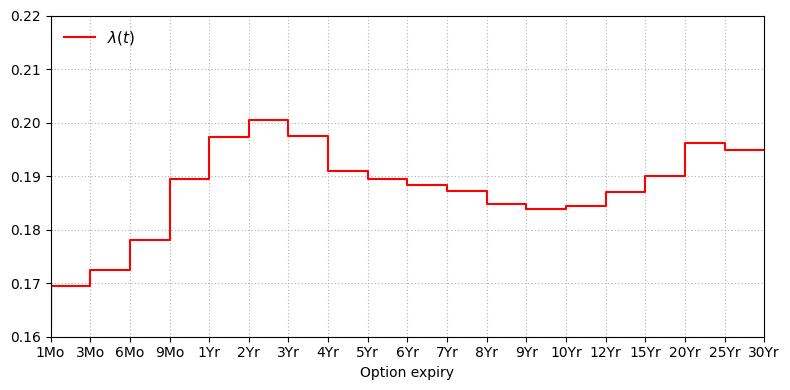

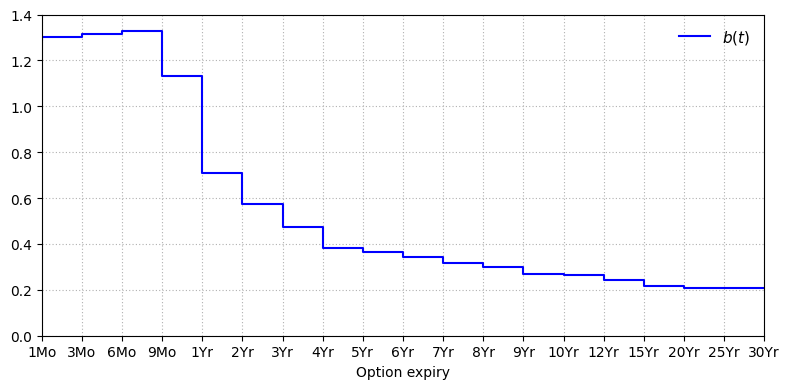

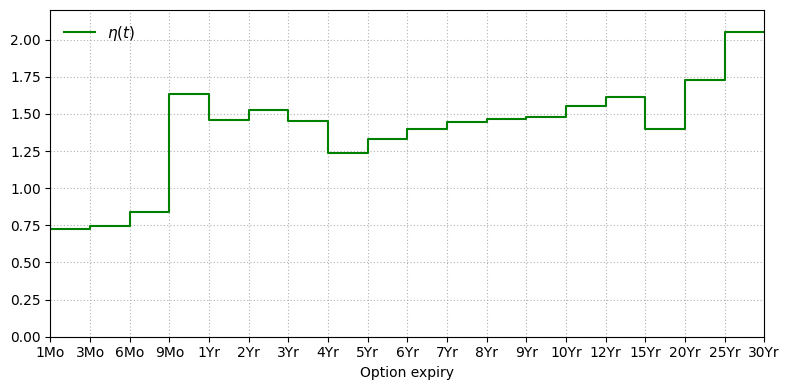

In [46]:
fig, ax = plt.subplots(figsize=(8,4))

ax.set_ylim(0.16,0.22)
ax.set_xlim(0, 18)
ax.set_xlabel('Option expiry')
plt.step(lambd_calibrated.index, lambd_calibrated, label = '$\\lambda(t)$', color = 'r')
plt.legend(frameon=False, loc = 'upper left', fontsize=11)
ax.grid(ls = (0,(1,2)))
fig.tight_layout()

plt.show()

fig, ax = plt.subplots(figsize=(8,4))

ax.set_ylim(0,1.4)
ax.set_xlim(0, 18)
ax.set_xlabel('Option expiry')
plt.step(b_calibrated.index, b_calibrated, label = '$b(t)$', color = 'b')
plt.legend(frameon=False, loc = 'upper right', fontsize=11)
ax.grid(ls = (0,(1,2)))
fig.tight_layout()

plt.show()

fig, ax = plt.subplots(figsize=(8,4))

ax.set_ylim(0,2.2)
ax.set_xlim(0, 18)
ax.set_xlabel('Option expiry')
plt.step(eta_calibrated.index, eta_calibrated, label = '$\\eta(t)$', color = 'g')
plt.legend(frameon=False, loc = 'upper left', fontsize=11)
ax.grid(ls = (0,(1,2)))
fig.tight_layout()

plt.show()

### Model implied volatilities

In [48]:
expiries = ["2Yr", "5Yr", "8Yr", "10Yr", "15Yr","20Yr"]
strike_index = np.array([200, 100, 50, 25, 0, -25, -50, -100, -200])

iv_smiles = []
for i in range(len(expiries)):
    expiry = expiries[i]
    smile_i = pd.Series([df_swaption_iv[0].loc[expiry, "10Yr"], df_swaption_iv[1].loc[expiry,"10Yr"], df_swaption_iv[2].loc[expiry,"10Yr"], df_swaption_iv[3].loc[expiry,"10Yr"], 
                         df_swaption_iv[4].loc[expiry,"10Yr"], # ATM
                         df_swaption_iv[5].loc[expiry,"10Yr"], df_swaption_iv[6].loc[expiry,"10Yr"], df_swaption_iv[7].loc[expiry,"10Yr"], df_swaption_iv[8].loc[expiry,"10Yr"]],
                         index = strike_index)
    iv_smiles.append(smile_i)

In [ ]:
expiries = pd.Series(data = np.array([1/12, 3/12, 6/12, 9/12, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 15, 20, 25, 30]), 
                     index = ["1Mo","3Mo","6Mo","9Mo","1Yr","2Yr","3Yr","4Yr", "5Yr", "6Yr","7Yr", "8Yr", "9Yr", "10Yr", "12Yr","15Yr","20Yr", "25Yr", "30Yr"])

points = ["2Yr", "5Yr", "8Yr", "10Yr", "15Yr","20Yr"]
IV_3 = []

for i in range(len(points)):
    lambd = lambd_calibrated[points[i]]
    eta = eta_calibrated[points[i]]
    b = b_calibrated[points[i]]

    S = swaprate_strips[4][points[i]]

    strikes = np.linspace(S -200/10000, S + 200/10000, 49)
    IV_index = np.round(np.linspace(-200, 200, len(strikes)),2)

    IV_i = pd.Series(np.zeros(len(strikes)),
                     index = IV_index)
  
    T = expiries[points[i]]
    print("T = ", T)

    for n in range(len(strikes)):

        K = strikes[n]    
        def Root_Solving(x):
            return bachelier(S, K, x, date, T, tenor, tau_floating, t = 0) - payer_price_SV(S, K, S, theta, eta, lambd, b, z_0, date, T, tenor)
        res = fsolve(Root_Solving, 0.01)

        IV_i.iloc[n] = res * 10000   # convert to bp
        print(IV_i.iloc[n])
        
    IV_3.append(IV_i)

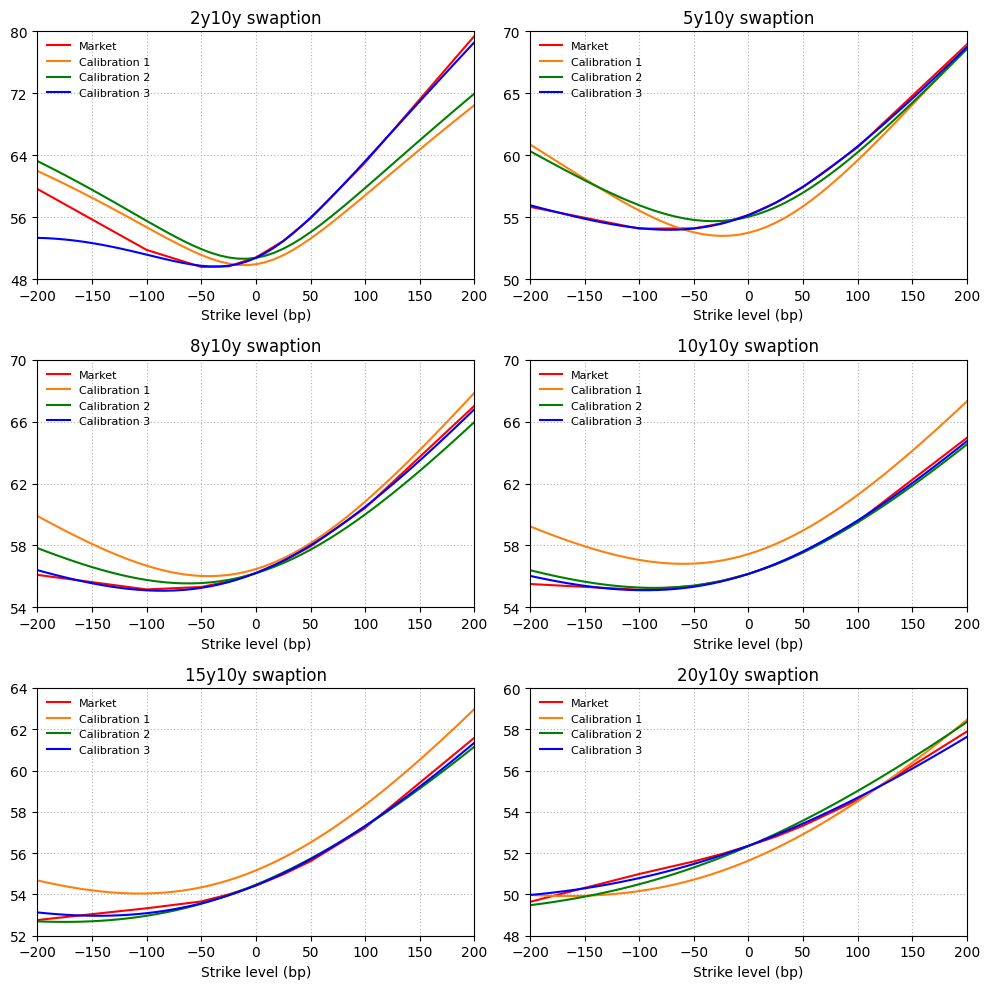

In [73]:
fig, ax = plt.subplots(3, 2, figsize=(10,10))

ax[0, 0].plot(iv_smiles[0].index, iv_smiles[0], label = 'Market', color = 'r')
ax[0, 0].plot(IV_1[0].index, IV_1[0], label = 'Calibration 1', color = '#ff7f0e')
ax[0, 0].plot(IV_2[0].index, IV_2[0], label = 'Calibration 2', color = 'g')
ax[0, 0].plot(IV_3[0].index, IV_3[0], label = 'Calibration 3', color = 'b')
ax[0, 0].set_title('2y10y swaption')
ax[0, 0].set_ylim(48,80)
ax[0, 0].set_yticks(np.arange(48,88,8))
ax[0, 0].set_xlim(min(IV_index), max(IV_index))
ax[0, 0].set_xlabel('Moneyness (bp)')
ax[0, 0].grid(ls = (0,(1,2)))
ax[0, 0].legend(frameon=False, fontsize=8)

ax[0, 1].plot(iv_smiles[1].index, iv_smiles[1], label = 'Market', color = 'r')
ax[0, 1].plot(IV_1[1].index, IV_1[1], label = 'Calibration 1', color = '#ff7f0e')
ax[0, 1].plot(IV_2[1].index, IV_2[1], label = 'Calibration 2', color = 'g')
ax[0, 1].plot(IV_3[1].index, IV_3[1], label = 'Calibration 3', color = 'b')
ax[0, 1].set_title('5y10y swaption')
ax[0, 1].set_ylim(50,70)
ax[0, 1].set_yticks(np.arange(50,75,5))
ax[0, 1].set_xlim(min(IV_index), max(IV_index))
ax[0, 1].set_xlabel('Moneyness (bp)')
ax[0, 1].grid(ls = (0,(1,2)))
ax[0, 1].legend(frameon=False, fontsize=8)

ax[1, 0].plot(iv_smiles[2].index, iv_smiles[2], label = 'Market', color = 'r')
ax[1, 0].plot(IV_1[2].index, IV_1[2], label = 'Calibration 1', color = '#ff7f0e')
ax[1, 0].plot(IV_2[2].index, IV_2[2], label = 'Calibration 2', color = 'g')
ax[1, 0].plot(IV_3[2].index, IV_3[2], label = 'Calibration 3', color = 'b')
ax[1, 0].set_title('8y10y swaption')
ax[1, 0].set_ylim(54,70)
ax[1, 0].set_yticks(np.arange(54,74,4))
ax[1, 0].set_xlim(min(IV_index), max(IV_index))
ax[1, 0].set_xlabel('Moneyness (bp)')
ax[1, 0].grid(ls = (0,(1,2)))
ax[1, 0].legend(frameon=False, fontsize=8)

ax[1, 1].plot(iv_smiles[3].index, iv_smiles[3], label = 'Market', color = 'r')
ax[1, 1].plot(IV_1[3].index, IV_1[3], label = 'Calibration 1', color = '#ff7f0e')
ax[1, 1].plot(IV_2[3].index, IV_2[3], label = 'Calibration 2', color = 'g')
ax[1, 1].plot(IV_3[3].index, IV_3[3], label = 'Calibration 3', color = 'b')
ax[1, 1].set_title('10y10y swaption')
ax[1, 1].set_ylim(54,70)
ax[1, 1].set_yticks(np.arange(54,74,4))
ax[1, 1].set_xlim(min(IV_index), max(IV_index))
ax[1, 1].set_xlabel('Moneyness (bp)')
ax[1, 1].grid(ls = (0,(1,2)))
ax[1, 1].legend(frameon=False, fontsize=8)

ax[2, 0].plot(iv_smiles[4].index, iv_smiles[4], label = 'Market', color = 'r')
ax[2, 0].plot(IV_1[4].index, IV_1[4], label = 'Calibration 1', color = '#ff7f0e')
ax[2, 0].plot(IV_2[4].index, IV_2[4], label = 'Calibration 2', color = 'g')
ax[2, 0].plot(IV_3[4].index, IV_3[4], label = 'Calibration 3', color = 'b')
ax[2, 0].set_title('15y10y swaption')
ax[2, 0].set_ylim(52,64)
ax[2, 0].set_xlim(min(IV_index), max(IV_index))
ax[2, 0].set_xlabel('Moneyness (bp)')
ax[2, 0].grid(ls = (0,(1,2)))
ax[2, 0].legend(frameon=False, fontsize=8)

ax[2, 1].plot(iv_smiles[5].index, iv_smiles[5], label = 'Market', color = 'r')
ax[2, 1].plot(IV_1[5].index, IV_1[5], label = 'Calibration 1', color = '#ff7f0e')
ax[2, 1].plot(IV_2[5].index, IV_2[5], label = 'Calibration 2', color = 'g')
ax[2, 1].plot(IV_3[5].index, IV_3[5], label = 'Calibration 3', color = 'b')
ax[2, 1].set_title('20y10y swaption')
ax[2, 1].set_ylim(48,60)
ax[2, 1].set_xlim(min(IV_index), max(IV_index))
ax[2, 1].set_xlabel('Moneyness (bp)')
ax[2, 1].grid(ls = (0,(1,2)))
ax[2, 1].legend(frameon=False, fontsize=8)

fig.tight_layout()
plt.show()

## Errors across all option expiries
##### Model

In [ ]:
expiries = pd.Series(data = np.array([1/12, 3/12, 6/12, 9/12, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 15, 20, 25, 30]), 
                     index = ["1Mo","3Mo","6Mo","9Mo","1Yr","2Yr","3Yr","4Yr", "5Yr", "6Yr","7Yr", "8Yr", "9Yr", "10Yr", "12Yr","15Yr","20Yr", "25Yr", "30Yr"])

points = ["2Yr","3Yr","4Yr", "5Yr", "6Yr","7Yr", "8Yr", "9Yr", "10Yr", "12Yr","15Yr","20Yr", "25Yr", "30Yr"]

IV_3_errors = []

for i in range(len(points)):

    lambd = lambd_calibrated[points[i]]
    b = b_calibrated[points[i]]
    eta = eta_calibrated[points[i]]

    S = swaprate_strips[4][points[i]]

    strikes = np.array([S-200/10000, S-100/10000, S-50/10000, S-25/10000,
                        S-0/10000,
                        S+25/10000, S+50/10000, S+100/10000, S+200/10000])

    IV_index = np.round(np.linspace(-200, 200, len(strikes)),2)

    IV_i = pd.Series(np.zeros(len(strikes)),
                     index = IV_index)
  
    T = expiries[points[i]]
    print("T = ", T)

    for n in range(len(strikes)):

        K = strikes[n]
        def Root_Solving(x):
            return bachelier(S, K, x, date, T, tenor, tau_floating, t = 0) - payer_price_SV(S, K, S, theta, eta, lambd, b, z_0, date, T, tenor)
        res = fsolve(Root_Solving, 0.01)

        IV_i.iloc[n] = res * 10000   # convert to bp
        print(IV_i.iloc[n])

    IV_3_errors.append(IV_i)

##### Market

In [76]:
expiries = ["2Yr","3Yr","4Yr", "5Yr", "6Yr","7Yr", "8Yr", "9Yr", "10Yr", "12Yr","15Yr","20Yr", "25Yr", "30Yr"]
strike_index = np.array([-200, -100, -50, -25, 0, 25, 50, 100, 200])

iv_smiles = []

for i in range(len(expiries)):
    expiry = expiries[i]
    smile_i = pd.Series([df_swaption_iv[8].loc[expiry,"10Yr"], df_swaption_iv[7].loc[expiry,"10Yr"], df_swaption_iv[6].loc[expiry,"10Yr"], df_swaption_iv[5].loc[expiry,"10Yr"],                   
                         df_swaption_iv[4].loc[expiry,"10Yr"], # ATM
                         df_swaption_iv[3].loc[expiry,"10Yr"], df_swaption_iv[2].loc[expiry,"10Yr"], df_swaption_iv[1].loc[expiry,"10Yr"], df_swaption_iv[0].loc[expiry, "10Yr"]],
                         index = strike_index)
    iv_smiles.append(smile_i)

In [77]:
rmse = []

for i in range(len(points)):

    rmse_i = np.sqrt(mean_squared_error(iv_smiles[i], IV_3_errors[i]))
    rmse.append(rmse_i)

avg_rmse = np.average(rmse)
display(pd.DataFrame(data= rmse, index = expiries, columns = ['RMSE, Calibration 3']))
print("Average root mean squared error =", avg_rmse)

,"RMSE, Calibration 3"
2Yr,2.131939
3Yr,0.849022
4Yr,0.248590
5Yr,0.090700
6Yr,0.109155
7Yr,0.124947
8Yr,0.134275
9Yr,0.140152
10Yr,0.193589
12Yr,0.151807


Average root mean squared error = 0.35438463196514336
